In [1]:
%run 'ks25_Read_epistasis.ipynb'

/home/katya/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


ImportError: No module named pymol

11510
259

Reading precalculated epistasis...
/home/katya/start/HIS3InterspeciesEpistasis/Analysis/Karen/files_dump/epistasis_in_foursomes/



Variables: 

- ep_dict: a dictionary, Keys are tuples (mutA, mutB) and values are pandas.Series of epistasis between mutA and mutB in all backgrounds. 
Tuples (mutA, mutB) are sorted by aa_position.

- get_ep_summary: a function that takes ep_dict as an argument and applies an arbitrary function to every pd.Series object. For example, ep_summary = get_ep_summary(ep_dict, np.mean)

- get_ep_summary_by_positions: a function that uses get_ep_summary and then averages results by position_pair. For example, get_ep_summary_by_positions(ep_dict, np.max, np.mean) will apply np.max to epistasis series and then use np.mean to average across a position pair. 

Important: natlib_filtering is currently True. This can be changed in the cell #2.



In [107]:
# getting segment numbers for every position
position_to_segment = {}
for segment in positions.segment:
    for position in positions.set_index('segment').loc[segment]['positions_Uniprot_P06633']:
        position_to_segment[position] = segment

In [108]:
def get_strong_epistasis_percents(series_of_impacts, threshold=0.4):
    negative = series_of_impacts[series_of_impacts < -1 * threshold]
    positive = series_of_impacts[series_of_impacts > threshold]
    neutral = series_of_impacts[(series_of_impacts <= threshold) & (series_of_impacts >= -1 * threshold)]
    fraction_negative = 1. * len(negative) / len(series_of_impacts)
    fraction_positive = 1. * len(positive) / len(series_of_impacts)
    fraction_neutral = 1. * len(neutral) / len(series_of_impacts)
    return fraction_negative, fraction_neutral, fraction_positive

def get_epistatic_backgrounds(segment, mutA, mutB, backgrounds):
    mutAB_full_mutations = [get_AB(bg, mutA, mutB) for bg in backgrounds]
    mutAB_aaseq_list = []
    for m in mutAB_full_mutations:
        try:
            if 'scaled' not in segment: segment += '_scaled'
            aa_seq = find_genotype(data_natural[segment], m).aa_seq.values[0]
            mutAB_aaseq_list.append(aa_seq)
        except AttributeError:
            pass
    return mutAB_aaseq_list

In [265]:
ep_summary = get_ep_summary(ep_dict, lambda series: get_strong_epistasis_percents(series, threshold=0.5))
sorted_ep_summary = sorted(ep_summary, key=lambda k: max([ep_summary[k][0], ep_summary[k][2]]), reverse=True)

In [302]:
strong_epistasis_threshold = 0.5
ratio_threshold = 5
noise_cutoff = 100
sample_size = 10
funny_genotypes = defaultdict(list)
counter = 0
for mutA, mutB in sorted_ep_summary:
    segment = position_to_segment[int(mutA[:-1])]
    fractions = {ep_summary[mutA, mutB][0] : -1, ep_summary[mutA, mutB][2] : 1}
    major_peak = max(ep_summary[mutA, mutB][0], ep_summary[mutA, mutB][2])
    minor_peak = min(ep_summary[mutA, mutB][0], ep_summary[mutA, mutB][2])
    if minor_peak > 0:
        if major_peak / minor_peak > ratio_threshold and major_peak / minor_peak < noise_cutoff:
            filtered = ep_dict[mutA, mutB][ep_dict[mutA, mutB] * fractions[major_peak] > strong_epistasis_threshold]
            if len(filtered) > sample_size:
                minor_genotypes = filtered.sample(sample_size).index.values
                funny_genotypes[segment].extend(get_epistatic_backgrounds(segment, mutA, mutB, minor_genotypes))
    counter += 1
    if counter == 1000:
        break

In [344]:
strong_epistasis_threshold = 0.5
ratio_threshold = 5
noise_cutoff = 100
sample_size = 10
funny_genotypes = defaultdict(list)
counter = 0
for mutA, mutB in sorted_ep_summary:
    segment = position_to_segment[int(mutA[:-1])]
    
    fractions = {ep_summary[mutA, mutB][0] : -1, ep_summary[mutA, mutB][2] : 1}
    major_peak = max(ep_summary[mutA, mutB][0], ep_summary[mutA, mutB][2])
    minor_peak = min(ep_summary[mutA, mutB][0], ep_summary[mutA, mutB][2])
    if minor_peak > 0:
        if major_peak / minor_peak > ratio_threshold and major_peak / minor_peak < noise_cutoff:
            filtered = ep_dict[mutA, mutB][ep_dict[mutA, mutB] * fractions[minor_peak] > strong_epistasis_threshold]
            if len(filtered) > sample_size:
                minor_genotypes = []
                for sample in filtered.index.values:
                    if len(sample.split(':')) < 3 and sample!='':
                        minor_genotypes.append(sample)

                funny_genotypes[segment].extend(get_epistatic_backgrounds(segment, mutA, mutB, minor_genotypes))
    counter += 1
    if counter == 300:
        break

### 2. NN training

In [81]:
%run '../../Analysis/Katya/NN/scripts/Functions.ipynb'

/home/katya/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [259]:
true = {}
predicted = {}
fitness_potential = {}
hist = {}
weights = {}
old_weights = {}
biases = {}
aa_seq = {}
unique_mutations = {}
mutList = {}

In [260]:
min_max_scaler = MinMaxScaler()
n_iter = 500

chunk = 'S2'
print (chunk)
data, labels, unique_mutations[chunk], aa_seq[chunk] = read_data_all_positions(chunk)

scaledLabels = min_max_scaler.fit_transform(labels.reshape(-1,1))

x_train, x_valid, y_train, y_valid = train_test_split(data, scaledLabels, test_size = 0.01)

model = Sequential()

model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer='glorot_normal'))
model.add(Dense(2, activation='sigmoid', kernel_initializer='glorot_normal'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer=opt,
              loss='mean_squared_error',
              verbose=0)

hist[chunk] = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                        epochs=n_iter, batch_size=500, shuffle=True, verbose=0)

proba = model.predict_proba(data, batch_size=500, verbose=0)

weights[chunk] = model.layers[0].get_weights()[0]
biases[chunk] = model.layers[0].get_weights()[1]

true[chunk] = labels
predicted[chunk] = min_max_scaler.inverse_transform(proba)
predicted[chunk] = predicted[chunk].flatten()
fitness_potential[chunk] = data.dot(weights[chunk]) + biases[chunk]

S2


In [261]:
_,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
if R>0:
    fitness_potential[chunk]*=-1
    weights[chunk]*=-1

_,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
print chunk, '\t', R

S2 	-0.803119836477


In [345]:
epistaticGenotypesPotential = []
epistaticGenotypesFitness = []
for sq in funny_genotypes[chunk]:
    x = aa_seq[chunk]
    ind = x[x==sq].index[0]
    fp = data[ind].dot(weights[chunk])
    f = labels[ind]
    epistaticGenotypesPotential.append(fp)
    epistaticGenotypesFitness.append(f)

In [346]:
randomGenotypesPotential = []
randomGenotypesFitness = []
   
ind = aa_seq[chunk].sample(len(funny_genotypes[chunk])).index
randomGenotypesPotential = data[ind].dot(weights[chunk])
randomGenotypesFitness = labels[ind].flatten()

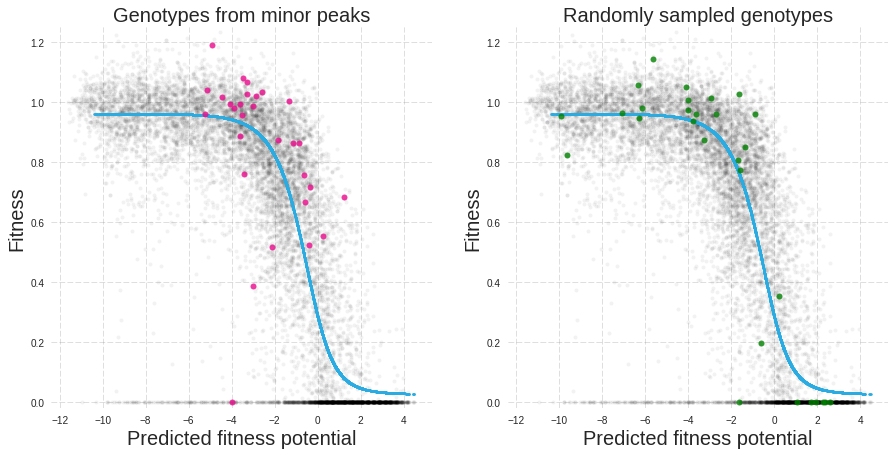

In [349]:
plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
plt.plot(fitness_potential[chunk][:10000], true[chunk][:10000], 'ok', alpha = 0.05, ms=4);
plt.plot(fitness_potential[chunk][:5000], predicted[chunk][:5000], '.', color='#2AACE2', alpha = 1, ms=5)
plt.plot(epistaticGenotypesPotential, epistaticGenotypesFitness,'o', color='#EA0A8C', alpha=0.8, ms=6)
plt.xlabel('Predicted fitness potential',fontsize=20)
plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray')
plt.ylabel('Fitness',fontsize=20)
plt.ylim(-0.02,1.25)
plt.title('Genotypes from minor peaks',fontsize=20)

plt.subplot(1,2,2)
plt.plot(fitness_potential[chunk][:10000], true[chunk][:10000], 'ok', alpha = 0.05, ms=4);
plt.plot(fitness_potential[chunk][:5000], predicted[chunk][:5000], '.', color='#2AACE2', alpha = 1, ms=5)
plt.plot(randomGenotypesPotential, randomGenotypesFitness,'o', color='green', alpha=0.8, ms=6)
plt.xlabel('Predicted fitness potential',fontsize=20)
plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray')
plt.ylabel('Fitness',fontsize=20)
plt.ylim(-0.02,1.25)
plt.title('Randomly sampled genotypes',fontsize=20);